In [2]:
import sys
sys.path.append('./')
import numpy as np
import os
import datetime
import keras.backend as K
import tensorflow as tf
from keras.layers import Conv2D, Dense, DepthwiseConv2D,add
from keras.optimizers import SGD, Adam
import numpy as np
import math
import keras
from PIL import Image
from random import shuffle
from keras import layers as KL
from Anchors import get_anchors
from Datasets import SSDDatasets
from learning_rate import WarmUpCosineDecayScheduler
from loss import MultiboxLoss
from Models import SSD300
from utils import get_classes, show_config
from log_record import record_log, read_log
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard)
from callbacks import (ExponentDecayScheduler, LossHistory,
                       ParallelModelCheckpoint, EvalCallback)


In [4]:
from keras.regularizers import l2

if __name__ == "__main__":
    
    # 设置训练参数
    Epoch = 150  # 训练100 epochs
    lr = 1e-3  # Adam优化器，所以较小的学习率
    optimizer_type = "Adam"
    momentum = 0.937
    batch_size = 32
    imgcolor = 'grey'  # imgcolor选“rgb” or “grey”, 则处理图像变单通道或者三通道
    tmp_dir = str(datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d'))
    save_dir = "/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/"+tmp_dir
    
    # 设置SSD参数
    cls_name_path = "./model_data/voc_classes.txt"  # 导入目标检测类别；
    input_shape = [120, 160]  # 输入的尺寸大小
    anchor_size = [32, 59, 86, 113, 141, 168]  # 用于设定先验框的大小，根据公式计算而来；如果要检测小物体，修改浅层先验框的大小，越小的话，识别的物体越小；    
    train_annotation_path = '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/Img_Pro/preprocessing/2007_trainval.txt'  # 训练图片路径和标签
    val_annotation_path = '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/Img_Pro/preprocessing/2007_test.txt'  # 验证图片路径和标签
    
    # 1. 获取classes和anchor
    class_names, num_cls = get_classes(cls_name_path)
    num_cls += 1  # 增加一个背景类别
    print("class_names:", class_names, "num_classes:", num_cls)
    
    # 2. 获取anchors, 输出的是归一化之后的anchors
    anchor = get_anchors(input_shape, anchor_size)
    print("type:",type(anchor), "shape:", np.shape(anchor))

    # 3. 模型编译
    K.clear_session()
    model_path = ""
    # model_path = "./output/20230804_3/good_detection_test_callback.h5"
    model = SSD300((input_shape[0], input_shape[1], 1), num_cls)
    # model.save("template.h5")
    # model.summary()
    if model_path != "":
        model.load_weights(model_path, by_name = True, skip_mismatch=True)
       
    # 4. 优化器
    # optimizer = Adam(lr = lr, beta_1=momentum)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # 5. 导入数据集
    with open(train_annotation_path, encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(val_annotation_path, encoding='utf-8') as f:
        val_lines = f.readlines()
    num_train = len(train_lines)
    num_val = len(val_lines)
    epoch_step = num_train // batch_size
    epoch_step_val = num_val // batch_size
    train_dataloader = SSDDatasets(train_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    val_dataloader = SSDDatasets(val_lines, input_shape, anchor, batch_size, num_cls, train=False, imgcolor=imgcolor)
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
    # 6. 编译模型
    # losses = {'mbox_loc_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,
            #   'cls_conf_final':MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss}
    # losses2 = [MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loc_loss,MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_conf_loss]
    model.compile(optimizer=optimizer, loss = MultiboxLoss(num_cls, neg_pos_ratio=3.0).compute_loss)
    
    # 7. 设计learning rate;
    total_steps = int(Epoch * num_train / batch_size)
    # 7.1 compute the number of warmup batches.
    warmup_epochs = 10
    warmup_steps = int(warmup_epochs * num_train / batch_size)
    # 7.2 create the learning rate scheduler
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=lr,
                                            total_steps=total_steps,
                                            warmup_learning_rate=4e-06,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=20)
    time_str = datetime.datetime.strftime(datetime.datetime.now(), '%Y_%m_%d_%H_%M_%S')
    log_dir = os.path.join(save_dir, "loss_" + str(time_str))
    
    # # 8. 精度评价: pending --> 还没构建；
    eval_flag = True
    eval_period = 10
    eval_callback = EvalCallback(model, input_shape, anchor, class_names, num_cls, val_lines, log_dir, eval_flag=eval_flag, period = eval_period)
    show_config(
        classes_path=cls_name_path, model_path=model_path, input_shape=input_shape, \
        Epoch=Epoch, batch_size=batch_size, \
        lr=lr, optimizer_type=optimizer_type, momentum=momentum, \
        num_train=num_train, num_val=num_val
    )
    
    callbacks_list = [
        # 早停回调，keras.callbacks.EarlyStopping(monitor='val_accuracy'， patience=4)
        warm_up_lr, # 学习率的调整
        # 学习率调整方法2. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto',min_lr=0.000001),
        # Epoch结束回调LearningRateSchrduler(schrduler, verbose=1),
        keras.callbacks.TensorBoard(log_dir=os.path.join(save_dir, 'unetlogs'), update_freq=1000), #参数分别为日志存储路径和每多少step进行一次记录，此处不应取太小，会拖慢训练过程
        eval_callback,  # 精度评价；
    ]
    # 8. 开始训练；
    history = model.fit_generator(
        generator=train_dataloader,
        steps_per_epoch=epoch_step,
        validation_data=val_dataloader,
        validation_steps=epoch_step_val,
        epochs=Epoch,
        # callbacks = [warm_up_lr]
        callbacks = callbacks_list   
    )  # 使用tensorboard --logdir="" 调用查看loss
    
    record_log(history, filename = os.path.join(save_dir, "unetlogs/log.txt"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.h5"))
    model.save(os.path.join(save_dir, "good_detection_test_callback_2.pb"))

class_names: ['good'] num_classes: 2
type: <class 'numpy.ndarray'> shape: (1242, 4)
Train on 1603 samples, val on 179 samples, with batch size 32.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|             classes_path |             ./model_data/voc_classes.txt|
|               model_path |                                         |
|              input_shape |                               [120, 160]|
|                    Epoch |                                      150|
|               batch_size |                                       32|
|                       lr |                                    0.001|
|           optimizer_type |                                     Adam|
|                 momentum |                                    0.937|
|                num_train |                            

2023-08-19 07:19:20.410890: W tensorflow/c/c_api.cc:291] Operation '{name:'Conv2D_loc_DD5_2/kernel/Assign' id:1567 op device:{requested: '', assigned: ''} def:{{{node Conv2D_loc_DD5_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Conv2D_loc_DD5_2/kernel, Conv2D_loc_DD5_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_17687/3038357533.py:98: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-08-19 07:19:20.655189: W tensorflow/c/c_api.cc:291] Operation '{name:'beta_1/Assign' id:1911 op device:{requested: '', assigned: ''} def:{{{node beta_1/Assign}} = AssignVariableOp[_has_m

 3/50 [>.............................] - ETA: 3s - batch: 1.0000 - size: 32.0000 - loss: 7.4510     

2023-08-19 07:19:22.502041: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-08-19 07:19:22.502067: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-08-19 07:19:22.577554: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-08-19 07:19:22.579281: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-08-19 07:19:22.579405: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/unetlogs/plugins/profile/2023_08_19_07_19_22/SSSLXSRVLS001.xplane.pb


50/50 [==============================] - ETA: 0s - batch: 24.5000 - size: 32.0000 - loss: 7.5389

2023-08-19 07:19:26.309262: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/AddN' id:1780 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/Conv2D_layer13/kernel/Regularizer/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


50/50 [==============================] - 6s 85ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.5389 - val_loss: 7.4990
Epoch 2/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.4851 - val_loss: 7.4135
Epoch 3/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 7.3045 - val_loss: 6.9101
Epoch 4/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 6.5722 - val_loss: 6.3068
Epoch 5/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 6.1325 - val_loss: 5.9284
Epoch 6/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.7069 - val_loss: 5.4933
Epoch 7/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.4429 - val_loss: 5.3549
Epoch 8/150
50/50 [==============================] - 4s 83ms/step - batch: 24.500

100%|██████████| 179/179 [00:01<00:00, 118.69it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
1.91% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 1.91%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' created successfully.
Get map done.
50/50 [==============================] - 7s 139ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.2059 - val_loss: 5.1603
Epoch 11/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1969 - val_loss: 5.1649
Epoch 12/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1716 - val_loss: 5.1462
Epoch 13/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1428 - val_loss: 5.1510
Epoch 14/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1743 - val_loss

100%|██████████| 179/179 [00:01<00:00, 118.87it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
2.03% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 2.03%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 7s 137ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1442 - val_loss: 5.1105
Epoch 21/150
50/50 [==============================] - 4s 81ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0943 - val_loss: 5.1323
Epoch 22/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0817 - val_loss: 5.1103
Epoch 23/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1083 - val_loss: 5.1097
Epoch 24/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1083 - val_loss: 5.10

100%|██████████| 179/179 [00:01<00:00, 129.45it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
3.40% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 3.40%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 7s 133ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.1088 - val_loss: 5.1007
Epoch 31/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0935 - val_loss: 5.1218
Epoch 32/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0772 - val_loss: 5.1214
Epoch 33/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0936 - val_loss: 5.1009
Epoch 34/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0712 - val_loss: 5.10

100%|██████████| 179/179 [00:01<00:00, 120.98it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
2.34% = good AP 	||	score_threhold=0.5 : F1=0.00 ; Recall=0.00% ; Precision=0.00%
mAP = 2.34%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 7s 135ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0795 - val_loss: 5.1058
Epoch 41/150
50/50 [==============================] - 4s 81ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0763 - val_loss: 5.1087
Epoch 42/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0685 - val_loss: 5.1101
Epoch 43/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0726 - val_loss: 5.0988
Epoch 44/150
50/50 [==============================] - 4s 86ms/step - batch: 24.5000 - size: 32.0000 - loss: 5.0814 - val_loss: 5.11

100%|██████████| 179/179 [00:01<00:00, 128.15it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
72.99% = good AP 	||	score_threhold=0.5 : F1=0.75 ; Recall=67.60% ; Precision=83.45%
mAP = 72.99%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 7s 134ms/step - batch: 24.5000 - size: 32.0000 - loss: 3.7890 - val_loss: 3.6119
Epoch 51/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 3.4622 - val_loss: 3.3770
Epoch 52/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 3.2126 - val_loss: 3.1410
Epoch 53/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 3.1171 - val_loss: 3.1259
Epoch 54/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.9147 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 157.92it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
91.21% = good AP 	||	score_threhold=0.5 : F1=0.90 ; Recall=87.15% ; Precision=92.86%
mAP = 91.21%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 113ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.2415 - val_loss: 2.3852
Epoch 61/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.1809 - val_loss: 2.1736
Epoch 62/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.0663 - val_loss: 2.1825
Epoch 63/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 2.0130 - val_loss: 2.0535
Epoch 64/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.9154 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 167.60it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
97.38% = good AP 	||	score_threhold=0.5 : F1=0.95 ; Recall=94.41% ; Precision=95.48%
mAP = 97.38%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 5s 110ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.6965 - val_loss: 1.9077
Epoch 71/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.6793 - val_loss: 1.8159
Epoch 72/150
50/50 [==============================] - 4s 85ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5961 - val_loss: 1.8199
Epoch 73/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5997 - val_loss: 1.7949
Epoch 74/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.5786 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 165.27it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
97.47% = good AP 	||	score_threhold=0.5 : F1=0.96 ; Recall=96.65% ; Precision=96.11%
mAP = 97.47%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 110ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4416 - val_loss: 1.7182
Epoch 81/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4388 - val_loss: 1.7162
Epoch 82/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4096 - val_loss: 1.7081
Epoch 83/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.4073 - val_loss: 1.7269
Epoch 84/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3995 - val_loss: 

100%|██████████| 179/179 [00:01<00:00, 155.70it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.52% = good AP 	||	score_threhold=0.5 : F1=0.95 ; Recall=95.53% ; Precision=95.00%
mAP = 98.52%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 112ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3670 - val_loss: 1.6841
Epoch 91/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.3177 - val_loss: 1.6490
Epoch 92/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2861 - val_loss: 1.6618
Epoch 93/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2838 - val_loss: 1.6442
Epoch 94/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2826 - val_loss: 

100%|██████████| 179/179 [00:00<00:00, 191.52it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.98% = good AP 	||	score_threhold=0.5 : F1=0.96 ; Recall=96.09% ; Precision=96.09%
mAP = 98.98%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 5s 107ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2248 - val_loss: 1.6404
Epoch 101/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2265 - val_loss: 1.6227
Epoch 102/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2022 - val_loss: 1.6415
Epoch 103/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.2140 - val_loss: 1.6272
Epoch 104/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1955 - val_lo

100%|██████████| 179/179 [00:01<00:00, 158.34it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.78% = good AP 	||	score_threhold=0.5 : F1=0.96 ; Recall=96.09% ; Precision=95.03%
mAP = 98.78%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 110ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1581 - val_loss: 1.6236
Epoch 111/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1544 - val_loss: 1.6165
Epoch 112/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1655 - val_loss: 1.6231
Epoch 113/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1543 - val_loss: 1.6168
Epoch 114/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1266 - val_lo

100%|██████████| 179/179 [00:01<00:00, 171.82it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.58% = good AP 	||	score_threhold=0.5 : F1=0.96 ; Recall=96.65% ; Precision=96.11%
mAP = 98.58%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 5s 109ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1249 - val_loss: 1.6118
Epoch 121/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1372 - val_loss: 1.6240
Epoch 122/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1027 - val_loss: 1.6012
Epoch 123/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1262 - val_loss: 1.6055
Epoch 124/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0941 - val_lo

100%|██████████| 179/179 [00:01<00:00, 157.49it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.72% = good AP 	||	score_threhold=0.5 : F1=0.97 ; Recall=97.21% ; Precision=96.67%
mAP = 98.72%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 112ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0928 - val_loss: 1.6008
Epoch 131/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0903 - val_loss: 1.6044
Epoch 132/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1251 - val_loss: 1.6070
Epoch 133/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1002 - val_loss: 1.5995
Epoch 134/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0929 - val_lo

100%|██████████| 179/179 [00:01<00:00, 160.55it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.73% = good AP 	||	score_threhold=0.5 : F1=0.97 ; Recall=97.21% ; Precision=96.67%
mAP = 98.73%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 5s 110ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1076 - val_loss: 1.6032
Epoch 141/150
50/50 [==============================] - 4s 82ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0702 - val_loss: 1.6046
Epoch 142/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0832 - val_loss: 1.6010
Epoch 143/150
50/50 [==============================] - 4s 83ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.1005 - val_loss: 1.6015
Epoch 144/150
50/50 [==============================] - 4s 84ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0736 - val_lo

100%|██████████| 179/179 [00:00<00:00, 185.33it/s]


Calculate Map.
Path '.temp_map_out/results' already exists.
98.74% = good AP 	||	score_threhold=0.5 : F1=0.97 ; Recall=97.21% ; Precision=96.67%
mAP = 98.74%
Path '/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/loss_2023_08_19_07_19_20' already exists.
Get map done.
50/50 [==============================] - 6s 110ms/step - batch: 24.5000 - size: 32.0000 - loss: 1.0871 - val_loss: 1.6008


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/good_detection_test_callback_2.pb/assets


INFO:tensorflow:Assets written to: /home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/good_detection_test_callback_2.pb/assets


no accuracy, only loss.


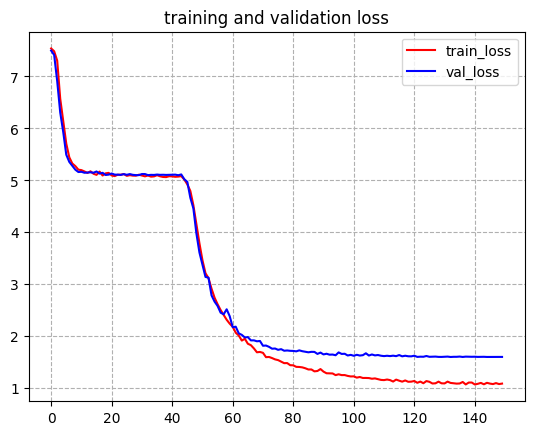

In [1]:
from log_record import record_log, read_log
from utils import visual_train

history = read_log("/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb_transfer_callback/output/20230819/unetlogs/log.txt")
visual_train(history)

no accuracy, only loss.


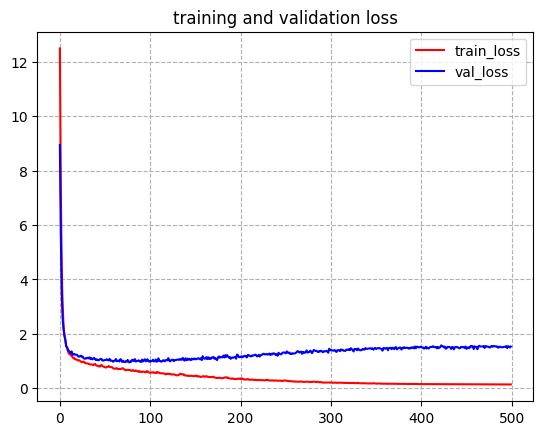

In [1]:
from log_record import record_log, read_log
from utils import visual_train

history = read_log("/home/zhangyouan/桌面/zya/NN_net/network/SSD/IMX_681_ssd_mobilenet_git/keras/detection/SSD_ipynb/output/20230816_1/unetlogs/log.txt")
visual_train(history)